# **Zombie Model**

**Agents**

My model consists of individuals with one defining characteristic: Zombie or Human. To accomplish my aim (see how long humans survive), I will also include an age attribute for human agents. This will count the number of iterations a human has survived for.

Humans behave normally and try to stay human by avoiding zombies. The nature of zombies makes it difficult to describe ‘behavior’, simply put zombies want to eat human brains.

**Actions**

Human agents will move to increase the distance between them and the closest zombie, while zombie agents will move closer to decrease this distance. If there are equally close zombies/humans, then one will be picked at random and treated as the closest (improvements can be made so that humans make ‘smarter’ decisions when avoiding multiple zombies).  If there is a zombie-human interaction (a zombie catches a human) then the human becomes a zombie. In my model the humans have no behaviors allowing for resistance, so all interactions have this result.

**Environment**

The agents will exist in a spatial environment. I’ll create it as a 10×10 grid where each cell can only have one occupant. Each agent has full visibility of all other agents and can only move to adjacent tiles (including diagonals) as part of their movement action. Interaction occurs between zombies and agents on adjacent tiles. There are no interactions between the agents and the environment.



**Simulation**

The model will begin by randomly placing ten agents in the environment. Nine agents will be human and one will be a zombie. Each agent is assigned an age of 0 at the commencement.

Each iteration is an arbitrary time period over which every agent is given the opportunity to act. Agents will be considered in a random order and their actions will take effect before continuing to the next agent. At the end of the iteration each human agent is aged by 1.

Once the basic components of an agent-based model are set up, it is easier to include other factors. Here are some interesting additions that could be made to the model:

* **Obstacles** – stationary objects in the environment that humans might be able to use for cover.
* **Limit visibility** – give zombies a higher range of visibility because of their smell (while humans rely on sight which is shorter).
* **Change movement range** – allow humans to move quicker (ie. two cells at a time).
* **Fight behavior** – when interaction occurs between human and zombie the human could avoid getting bitten.


In [28]:
! pip install mesa

In [29]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

In [30]:
import math
import random
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import imageio
import os

%matplotlib inline

In [31]:
def euclidean_dist(pos1, pos2):
    """
    finds distance between two points given as coordinate tuple (x, y)
    """
    
    x1, y1 = pos1 
    x2, y2 = pos2 
    
    dx = x1 - x2
    dy = y1 - y2 
    
    return math.sqrt(dx**2 + dy**2)

In [32]:
def create_gif(file_list, destination_folder, gif_name):
    """
    Creates a GIF file of a list of .png files
    ----------
    file_list : list - of file names to create gif from.
    destination_folder : str - Name of folder in which to save gif.
    gif_name : str - Name of new gif to be saved.
    """
    
    images = []
    for filename in file_list:
        images.append(imageio.imread(filename))
    imageio.mimsave(os.path.join(destination_folder, gif_name+'.gif'), images, duration = .75)

In [33]:
class ZombieModel(Model):
    """ The model with some number of agents - either Human or Zombie """
    def __init__(self, human_number, grid_size, zombie_pos, startup_pos):
        self.humans = human_number
        self.total_agents = human_number + 1
        self.grid_size = grid_size
        self.startup_pos = startup_pos
        
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(grid_size, grid_size, False)
        
        ## only one zombie to start
        agent_creation_list = ['zombie'] + ['human']*human_number
        
        # create list of all possible x, y coordinates as tuples - so each coordinate can only have one agent
        all_coords = []
        for x in range(grid_size):
            for y in range(grid_size):
                all_coords += [(x, y)]
        
        # create the agents
        for n in range(self.total_agents):
            agent = SubjectAgent(n, agent_creation_list[n], self)
            
            ## add agent to the schedule
            self.schedule.add(agent)
            
            ## add agent to the grid
            if agent.state == 'zombie':
                if zombie_pos == ('?', '?'):
                    agent_coords = random.choice(all_coords)
                else:
                    agent_coords = zombie_pos
                all_coords.remove(agent_coords)
            elif self.startup_pos == []:
                agent_coords = random.choice(all_coords)
                all_coords.remove(agent_coords)
            else:
                agent_coords = self.startup_pos[n]
            
            agent.start_pos = agent_coords
            self.grid.place_agent(agent, agent_coords)
    
    
    def step(self):
        self.schedule.step()
        
        for x in self.schedule.agents:
            if x.state == 'zombie':
                x.zombie_age += 1
            elif x.state == 'human':
                x.human_age += 1


In [34]:
class SubjectAgent(Agent):
    """ An Agent which can be a Human or Zombie """
    
    def __init__(self, unique_id, state, model):
        super().__init__(unique_id, model)
        self.state = state # human or zombie 
        self.orig_state = state # human or zombie 
        self.zombie_age = 1 if state == 'zombie' else 0
        self.human_age = 0
        self.speed = 1 # radius of movement
    
    # iterator    
    def step(self):
        
        self.locate_target()
        self.move()
        
        pass
    
    def locate_target(self):
        ## find the closest agent of opposite type
        possible_targets = [agent for agent in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False, radius = self.model.grid_size)
                            if agent.state != self.state]
        
        # shuffle because 'get_neighbors' tends to order the list from bottom-left to top-right 
        ## in the case of equally distant targets it stops the target all being assigned to the most bottom-left
        random.shuffle(possible_targets)
        
        if len(possible_targets) == 0:
            self.target = []
        else:
            tar_euclidean_dist = [(euclidean_dist(self.pos, agent.pos), agent) for agent in possible_targets]
            tar_euclidean_dist.sort(key=lambda tup: tup[0])
            self.target = tar_euclidean_dist[0][1]
    
    
    def move(self):
        # get agent's movement options 
        ## Note: if speed is increased for some then extra logic must be incorporated so that agents do not move to 'blocked' cells
        movement_options = [coord for coord in self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius = self.speed)
                            if self.model.grid.is_cell_empty(coord)] + [self.pos]
        
        # shuffle because 'get_neighborhood' tends to order the list from bottom-left to top-right 
        ## in the case of equally good movement options this stops the new coords being always chosen as the most bottom-left option
        random.shuffle(movement_options)
        
        
        if self.target == []:
            # if there are no agents remaining of the opposite type
            self.model.grid.move_agent(self, random.choice(movement_options))
        
        elif self.state == 'human':
            
            dist_from_target = [(euclidean_dist(self.target.pos, coord), coord) for coord in movement_options]
            dist_from_target.sort(key=lambda tup: tup[0], reverse=True)
            
            new_coords = dist_from_target[0][1]
            self.model.grid.move_agent(self, new_coords)
        
        elif self.state == 'zombie' and self.zombie_age >= 1:
            
            # see if the zombie is adjacent to it's target human
            adj_target = [human for human in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False, radius = 1) if human.unique_id == self.target.unique_id]
            if len(adj_target) > 0:
                self.target.state = 'zombie'
            else:
                dist_from_target = [(euclidean_dist(self.target.pos, coord), coord) for coord in movement_options]
                dist_from_target.sort(key=lambda tup: tup[0], reverse=False)
                
                new_coords = dist_from_target[0][1]
                self.model.grid.move_agent(self, new_coords)

Running the model

In [35]:
seed_total = 2000
output_vis = True
start_humans = 9
place_zombie = ('?', '?') # Random Zombie Start
grid_size = 15
folder = 'ZombieModelOutput'

In [36]:
# create the folder for storing images/gifs
if output_vis:
    try: 
        os.makedirs(folder)
    except OSError as e:
        if 'File exists' != e.strerror:
            raise

In [37]:
## empty lists/dicts for storing model results
t_results = []
age_average = []
age_position = {}
for x in range(grid_size):
    for y in range(grid_size):
        age_position[(x, y)] = []
        

In [38]:
## set up grid size and plot formatting
## color
color_dict = {'human': 'blue', 'zombie': 'red'}
# create the axis ticks - complicated because I want my output to look like a grid
i = -0.5 
ticks = []
while i < grid_size:
    ticks += [i]
    i += 1

In [39]:
for seed in range(seed_total):    
    
    ZombieHunt = ZombieModel(start_humans, grid_size, place_zombie, [])
    file_list = []
    
    # define the controlling parameters for the seed
    current_human_no = start_humans
    t = 0
    
    if seed%100 == 0:
        print('running seed '+str(seed)+'...')
    
    while current_human_no > 0 and t < 100:
        
        # only output 1 out of 10 seeds
        if output_vis and seed%(seed_total/10) == 0: 
            # extract data from model
            positions = [x.pos for x in ZombieHunt.schedule.agents]
            plot_color = [color_dict[x.state] for x in ZombieHunt.schedule.agents]
            #plot_labels = [str('Agent'+str(x.unique_id)) for x in ZombieHunt.schedule.agents]
            plot_labels = ['' for x in ZombieHunt.schedule.agents]
            
            # create graph
            x, y = zip(*positions)
            plt.scatter(x, y, c=plot_color, s=150)
            plt.title('seed '+str(seed)+', t = '+str(t))
            # plt.title('iteration = '+str(t))
            plt.xlim(-0.5, grid_size-0.5)
            plt.ylim(-0.5, grid_size-0.5)
            
            for i, txt in enumerate(plot_labels):
                plt.annotate(txt, (x[i], y[i]))
            
            plt.xticks(ticks, "")
            plt.yticks(ticks, "")
            plt.grid(b= True, which='major', axis='both', color='black', linestyle='-', linewidth=0.5)
            #plt.show()
            
            file_name = folder+'/seed'+str(seed)+'t'+str(t)+'.png'
            file_list += [file_name]
            
            # save image then clear
            plt.savefig(file_name)
            plt.clf()
        
        # advance the control parameters
        t += 1
        current_humans = [x.start_pos for x in ZombieHunt.schedule.agents if x.state == 'human']
        current_human_no = len(current_humans)
        
        # finally iterate the model (t=0 will appear just as the initialization of the model)
        ZombieHunt.step()
    
    # record the results from the seed
    t_results += [t]
    avg = [x.human_age for x in ZombieHunt.schedule.agents if x.orig_state == 'human']
    age_average += [sum(avg)/len(avg)]
    for x in ZombieHunt.schedule.agents:
        age_position[x.start_pos] += [x.human_age]
    
    # create the gif
    if output_vis and len(file_list) > 0:
        create_gif(file_list, folder, 'seed'+str(seed))


running seed 0...
running seed 10...
running seed 20...
running seed 30...
running seed 40...
running seed 50...
running seed 60...
running seed 70...
running seed 80...
running seed 90...
running seed 100...
running seed 110...
running seed 120...
running seed 130...
running seed 140...
running seed 150...
running seed 160...
running seed 170...
running seed 180...
running seed 190...
running seed 200...
running seed 210...
running seed 220...
running seed 230...
running seed 240...
running seed 250...
running seed 260...
running seed 270...
running seed 280...
running seed 290...
running seed 300...
running seed 310...
running seed 320...
running seed 330...
running seed 340...
running seed 350...
running seed 360...
running seed 370...
running seed 380...
running seed 390...
running seed 400...
running seed 410...
running seed 420...
running seed 430...
running seed 440...
running seed 450...
running seed 460...
running seed 470...
running seed 480...
running seed 490...
running see

<Figure size 432x288 with 0 Axes>

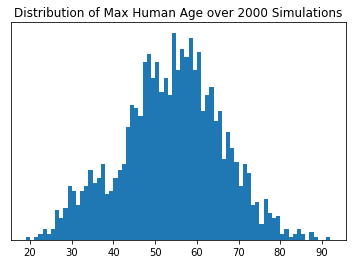

<Figure size 432x288 with 0 Axes>

In [48]:
# Histogram: Max human Age
plt.hist(t_results, bins=max(t_results)-min(t_results))
plt.title("Distribution of Max Human Age over "+str(seed_total)+" Simulations")
plt.yticks(list(range(120, 10)), "")
if output_vis:
    plt.savefig(folder+"/Max Human Age.png")
    plt.show()
    plt.clf()
else:
    plt.show()


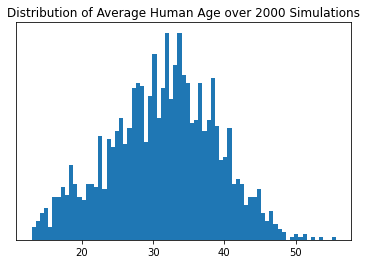

<Figure size 432x288 with 0 Axes>

In [47]:
# Histogram: Average Human Age
plt.hist(age_average, bins=int(np.ceil(max(t_results))-np.floor(min(t_results))))
plt.title("Distribution of Average Human Age over "+str(seed_total)+" Simulations")
plt.yticks(list(range(120, 10)), "")
if output_vis:
    plt.savefig(folder+"/Average Human Age.png")
    plt.show()
    plt.clf()
else:
    plt.show()

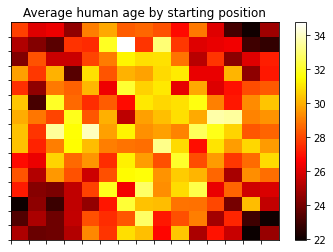

<Figure size 432x288 with 0 Axes>

In [49]:
# Heat Map: Average Human Age starting coords
plot_value = 'Average'
result_array = np.zeros((grid_size, grid_size))
for x in age_position:
    if plot_value == 'Average':
        result_array[x[1], x[0]] = 0 if len(age_position[x])==0 else sum(age_position[x])/len(age_position[x])
    if plot_value == 'Max':
        result_array[x[1], x[0]] = 0 if len(age_position[x])==0 else max(age_position[x])
    if plot_value == 'Min':
        result_array[x[1], x[0]] = 0 if len(age_position[x])==0 else min(age_position[x])

#plt.pcolor(result_array, cmap='hot', vmin = 0, vmax=15)
plt.pcolor(result_array, cmap='hot')

plt.title("Average human age by starting position")
plt.xticks(list(range(grid_size)), "")
plt.yticks(list(range(grid_size)), "")
plt.colorbar()
if output_vis:
    plt.savefig(folder+"/"+plot_value+" Human Age by Star Position.png")
    plt.show()
    plt.clf()
else:
    plt.show()